# Undersampling

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import imblearn
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import OneSidedSelection, NearMiss, CondensedNearestNeighbour, EditedNearestNeighbours
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import TomekLinks

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,classification_report,plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

## Pre-Processing

In [4]:
df = pd.read_csv("bank-additional-full.csv", delimiter=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
cols = df.columns
var_numerical = list(df._get_numeric_data().columns)
var_categorical = list(set(cols) - set(var_numerical) - set('y'))

In [6]:
# Default variable and Day of week has no impact on the client subscribing for term deposit.
df.drop(["default"], axis = 1, inplace=True)
df.drop(["day_of_week"], axis = 1, inplace=True)


In [7]:
df.drop(['emp.var.rate', 'nr.employed'], axis = 1, inplace=True)
var_numerical = list(set(var_numerical) - set(['emp.var.rate', 'nr.employed']))

In [8]:
# Get the dummy variables for contact, poutcome , job, month, marital,  education
# Let's drop the first column from  using 'drop_first = True' as first column can be derived using other columns 

df['job'] = df['job'].apply(lambda x: -1 if x=='unknown' or x=='unemployed' else (15 if x=='entrepreneur' else (8 if x == 'blue-collar' else ( 6 if x=='technician' or x=='services' or  x=='admin.' or x=='management' else (4 if x== 'self-employed' or x=='student' else (2 if x=='housemaid' or x=='retired' else None) )))))
df['housing'] = df['housing'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
df['loan'] = df['loan'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
df['y'] = df['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
df['poutcome'] = df['poutcome'].apply(lambda x: 0 if x=='failure' else (2 if x=='failure' else - 1))
df['pdays'] = df['pdays'].apply(lambda x: 0 if x==999 else(20 if x<=10 else(6 if x<=20 else 3)))

df  = pd.get_dummies(df, drop_first = True)

In [11]:
y = df.pop('y')

In [12]:
counter = Counter(y)
print(counter)

Counter({0: 36548, 1: 4640})


In [10]:
df.head()

,age,job,housing,loan,duration,campaign,pdays,previous,poutcome,cons.price.idx,...,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,56,2,0,0,261,1,0,0,-1,93.994,...,1,0,0,0,0,0,1,0,0,0
1,57,6,0,0,149,1,0,0,-1,93.994,...,1,0,0,0,0,0,1,0,0,0
2,37,6,1,0,226,1,0,0,-1,93.994,...,1,0,0,0,0,0,1,0,0,0
3,40,6,0,0,151,1,0,0,-1,93.994,...,1,0,0,0,0,0,1,0,0,0
4,56,6,0,1,307,1,0,0,-1,93.994,...,1,0,0,0,0,0,1,0,0,0


## Finding k

In [11]:
%%time
inertia = [] 
k = [2, 3, 4, 5, 10, 20, 30, 40, 50]
for i in k: 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 100)
    kmeans.fit(df) 
    inertia.append(kmeans.inertia_)

CPU times: total: 3min 28s
Wall time: 1min 2s


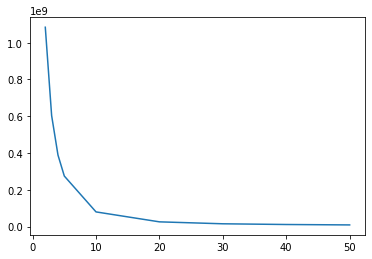

In [12]:
plt.plot(k, inertia)

## Near Miss Undersampling

In [13]:
undersample_nm = NearMiss(version=1, n_neighbors=10)

In [14]:
X_nm, y_nm = undersample_nm.fit_resample(df, y)

In [15]:
cnt_nm = Counter(y_nm)
print(cnt_nm)

Counter({0: 4640, 1: 4640})


In [16]:
X_train_nm, X_test_nm, y_train_nm, y_test_nm = train_test_split(X_nm, y_nm, test_size = 0.2, random_state = 100)

In [17]:
dtclf = DecisionTreeClassifier( max_depth=8, criterion='gini',class_weight= {0:1,1:1})
dtclf= dtclf.fit(X_train_nm,y_train_nm)

In [18]:
y_pred_nm = dtclf.predict(X_test_nm)
print(accuracy_score(y_test_nm,y_pred_nm))
print(classification_report(y_test_nm, y_pred_nm))

0.8550646551724138
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       931
           1       0.89      0.81      0.85       925

    accuracy                           0.86      1856
   macro avg       0.86      0.85      0.85      1856
weighted avg       0.86      0.86      0.85      1856



C:\Users\Abhishek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


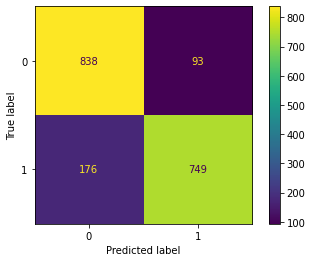

In [19]:
plot_confusion_matrix(dtclf, X_test_nm, y_test_nm)
plt.show()

In [20]:
nbclf = GaussianNB()
nbclf = nbclf.fit(X_train_nm, y_train_nm)

In [21]:
y_pred_nm = nbclf.predict(X_test_nm)
print(accuracy_score(y_test_nm,y_pred_nm))
print(classification_report(y_test_nm, y_pred_nm))

0.7893318965517241
              precision    recall  f1-score   support

           0       0.71      0.97      0.82       931
           1       0.95      0.61      0.74       925

    accuracy                           0.79      1856
   macro avg       0.83      0.79      0.78      1856
weighted avg       0.83      0.79      0.78      1856



C:\Users\Abhishek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


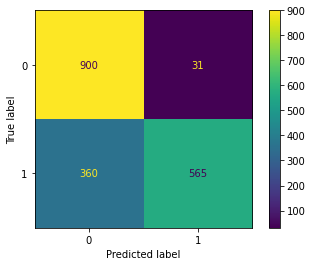

In [22]:
plot_confusion_matrix(nbclf, X_test_nm, y_test_nm)
plt.show()

In [23]:
rfclf= RandomForestClassifier(max_depth = 10, max_features= 25, n_estimators= 100,class_weight= {0:1,1:1})
rfclf= rfclf.fit(X_train_nm,y_train_nm)

In [24]:
y_pred_nm = rfclf.predict(X_test_nm)
print(accuracy_score(y_test_nm,y_pred_nm))
print(classification_report(y_test_nm, y_pred_nm))

0.8739224137931034
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       931
           1       0.90      0.84      0.87       925

    accuracy                           0.87      1856
   macro avg       0.88      0.87      0.87      1856
weighted avg       0.88      0.87      0.87      1856



C:\Users\Abhishek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


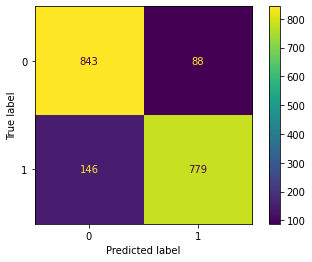

In [25]:
plot_confusion_matrix(rfclf, X_test_nm, y_test_nm)
plt.show()

## One Sided Selection Undersampling

In [32]:
undersample_oss = OneSidedSelection(n_neighbors=20, n_seeds_S=2000)

In [34]:
X_oss, y_oss = undersample_oss.fit_resample(df, y)

In [35]:
cnt_oss = Counter(y_oss)
print(cnt_oss)

Counter({0: 11053, 1: 4640})


In [36]:
X_train_oss, X_test_oss, y_train_oss, y_test_oss = train_test_split(X_oss, y_oss, test_size = 0.2, random_state = 100)

In [48]:
dtclf = DecisionTreeClassifier( max_depth=8, criterion='gini',class_weight= {0:1,1:2.38})
dtclf = dtclf.fit(X_train_oss,y_train_oss)

In [49]:
y_pred_oss = dtclf.predict(X_test_oss)
print(accuracy_score(y_test_oss,y_pred_oss))
print(classification_report(y_test_oss, y_pred_oss))

0.7948391207390889
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      2232
           1       0.60      0.85      0.70       907

    accuracy                           0.79      3139
   macro avg       0.76      0.81      0.77      3139
weighted avg       0.83      0.79      0.80      3139



C:\Users\Abhishek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


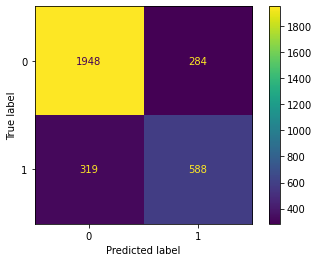

In [39]:
plot_confusion_matrix(dtclf, X_test_oss, y_test_oss)
plt.show()

In [50]:
rfclf= RandomForestClassifier(max_depth = 10, max_features= 25, n_estimators= 100,class_weight= {0:1,1:2.38})
rfclf= rfclf.fit(X_train_oss,y_train_oss)

In [51]:
y_pred_oss = rfclf.predict(X_test_oss)
print(accuracy_score(y_test_oss,y_pred_oss))
print(classification_report(y_test_oss, y_pred_oss))

0.8212806626314113
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      2232
           1       0.65      0.84      0.73       907

    accuracy                           0.82      3139
   macro avg       0.79      0.83      0.80      3139
weighted avg       0.85      0.82      0.83      3139



C:\Users\Abhishek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


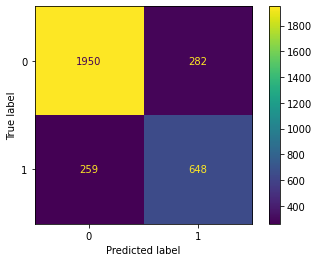

In [42]:
plot_confusion_matrix(rfclf, X_test_oss, y_test_oss)
plt.show()

In [43]:
nbclf = GaussianNB()
nbclf = nbclf.fit(X_train_oss, y_train_oss)


In [44]:
y_pred_oss = nbclf.predict(X_test_oss)
print(accuracy_score(y_test_oss,y_pred_oss))
print(classification_report(y_test_oss, y_pred_oss))

0.7645747053201657
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      2232
           1       0.66      0.39      0.49       907

    accuracy                           0.76      3139
   macro avg       0.72      0.65      0.67      3139
weighted avg       0.75      0.76      0.74      3139



C:\Users\Abhishek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


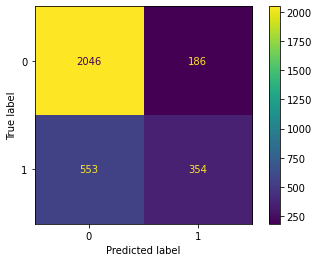

In [45]:
plot_confusion_matrix(nbclf, X_test_oss, y_test_oss)
plt.show()

## Edited Nearest Neighbors Rule

In [53]:
undersample_enn = EditedNearestNeighbours(n_neighbors = 10)

In [54]:
%%time
X_enn, y_enn = undersample_enn.fit_resample(df, y)

In [55]:
counter = Counter(y_enn)
print(counter)

Counter({0: 28148, 1: 4640})


In [56]:
X_train_enn, X_test_enn, y_train_enn, y_test_enn = train_test_split(X_enn, y_enn, test_size = 0.2, random_state = 100)

In [96]:
dtclf= DecisionTreeClassifier( max_depth = 8, criterion='gini',class_weight= {0:1.1,1:5})
dtclf= dtclf.fit(X_train_cnn,y_train_cnn)

In [97]:
y_pred_enn = dtclf.predict(X_test_enn)
print(accuracy_score(y_test_enn,y_pred_enn))
print(classification_report(y_test_enn, y_pred_enn))

0.7028057334553217
              precision    recall  f1-score   support

           0       0.99      0.66      0.79      5671
           1       0.31      0.96      0.47       887

    accuracy                           0.70      6558
   macro avg       0.65      0.81      0.63      6558
weighted avg       0.90      0.70      0.75      6558



C:\Users\Abhishek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


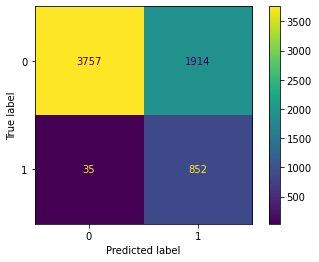

In [98]:
plot_confusion_matrix(dtclf, X_test_enn, y_test_enn)
plt.show()

In [61]:
rfclf= RandomForestClassifier(max_depth = 8, max_features= 25, n_estimators= 100,class_weight= {0:1,1:6.1})
rfclf= rfclf.fit(X_train_enn,y_train_enn)

In [62]:
y_pred_enn = rfclf.predict(X_test_enn)
print(accuracy_score(y_test_enn,y_pred_enn))
print(classification_report(y_test_enn, y_pred_enn))

0.9690454406831351
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5671
           1       0.84      0.95      0.89       887

    accuracy                           0.97      6558
   macro avg       0.92      0.96      0.94      6558
weighted avg       0.97      0.97      0.97      6558



C:\Users\Abhishek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


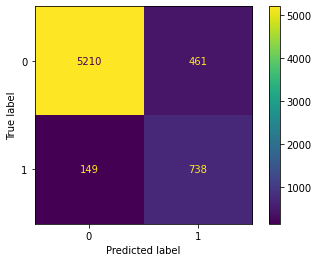

In [99]:
plot_confusion_matrix(rfclf, X_test_enn, y_test_enn)
plt.show()

In [90]:
nbclf = GaussianNB()
nbclf = nbclf.fit(X_train_enn, y_train_enn)

In [91]:
y_pred_enn = nbclf.predict(X_test_enn)
print(accuracy_score(y_test_enn,y_pred_enn))
print(classification_report(y_test_enn, y_pred_enn))

0.9326014028667277
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5671
           1       0.84      0.62      0.71       887

    accuracy                           0.93      6558
   macro avg       0.89      0.80      0.84      6558
weighted avg       0.93      0.93      0.93      6558



C:\Users\Abhishek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


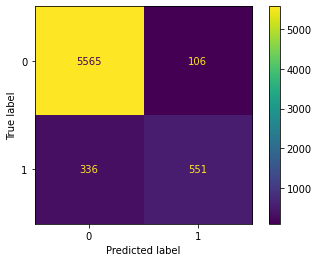

In [100]:
plot_confusion_matrix(nbclf, X_test_enn, y_test_enn)
plt.show()

## Condensed Nearest Neighbour

In [76]:
undersample_cnn = CondensedNearestNeighbour(n_neighbors=10)

In [77]:
%%time
X_cnn, y_cnn = undersample_cnn.fit_resample(df, y)

CPU times: total: 9h 30min 16s
Wall time: 2h 26min 45s


In [78]:
cnt = Counter(y_cnn)
print(cnt)

Counter({1: 4640, 0: 4535})


In [79]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_cnn, test_size = 0.2, random_state = 100)

In [80]:
dtclf= DecisionTreeClassifier( max_depth = 6, criterion='gini',class_weight= {0:1.1,1:1})
dtclf= dtclf.fit(X_train_cnn,y_train_cnn)

In [81]:
y_pred_cnn = dtclf.predict(X_test_cnn)
print(accuracy_score(y_test_cnn,y_pred_cnn))
print(classification_report(y_test_cnn, y_pred_cnn))

0.7307901907356948
              precision    recall  f1-score   support

           0       0.75      0.69      0.71       902
           1       0.72      0.77      0.75       933

    accuracy                           0.73      1835
   macro avg       0.73      0.73      0.73      1835
weighted avg       0.73      0.73      0.73      1835



C:\Users\Abhishek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


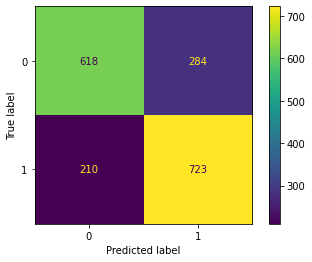

In [82]:
plot_confusion_matrix(dtclf, X_test_cnn, y_test_cnn)
plt.show()

In [83]:
rfclf= RandomForestClassifier(max_depth = 8, max_features= 25, n_estimators= 100,class_weight= {0:1,1:1})
rfclf= rfclf.fit(X_train_cnn,y_train_cnn)

In [84]:
y_pred_cnn = rfclf.predict(X_test_cnn)
print(accuracy_score(y_test_cnn,y_pred_cnn))
print(classification_report(y_test_cnn, y_pred_cnn))

0.7340599455040872
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       902
           1       0.72      0.78      0.75       933

    accuracy                           0.73      1835
   macro avg       0.74      0.73      0.73      1835
weighted avg       0.74      0.73      0.73      1835



C:\Users\Abhishek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


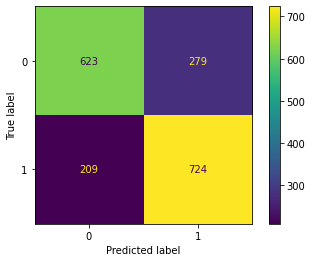

In [85]:
plot_confusion_matrix(rfclf, X_test_cnn, y_test_cnn)
plt.show()

In [86]:
nbclf = GaussianNB()
nbclf = nbclf.fit(X_train_cnn, y_train_cnn)

In [87]:
y_pred_cnn = nbclf.predict(X_test_cnn)
print(accuracy_score(y_test_cnn,y_pred_cnn))
print(classification_report(y_test_cnn, y_pred_cnn))

0.6016348773841962
              precision    recall  f1-score   support

           0       0.57      0.76      0.65       902
           1       0.66      0.45      0.53       933

    accuracy                           0.60      1835
   macro avg       0.62      0.60      0.59      1835
weighted avg       0.62      0.60      0.59      1835



C:\Users\Abhishek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


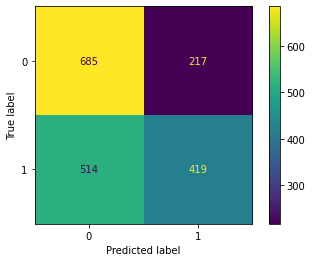

In [88]:
plot_confusion_matrix(nbclf, X_test_cnn, y_test_cnn)
plt.show()

## Tomek Links

In [104]:
undersample_tl = TomekLinks()

In [105]:
%%time
X_tl, y_tl = undersample.fit_resample(df, y)

CPU times: total: 20.2 s
Wall time: 3.49 s


In [106]:
cnt_tl = Counter(y_tl)
print(cnt_tl)

Counter({0: 28148, 1: 4640})


In [108]:
X_train_tl, X_test_tl, y_train_tl, y_test_tl = train_test_split(X_cnn, y_cnn, test_size = 0.2, random_state = 100)

In [109]:
dtclf= DecisionTreeClassifier( max_depth = 6, criterion='gini',class_weight= {0:1.1,1:5})
dtclf= dtclf.fit(X_train_tl,y_train_tl)

In [110]:
y_pred_tl = dtclf.predict(X_test_tl)
print(accuracy_score(y_test_tl,y_pred_tl))
print(classification_report(y_test_tl, y_pred_tl))

0.6544959128065395
              precision    recall  f1-score   support

           0       0.89      0.34      0.49       902
           1       0.60      0.96      0.74       933

    accuracy                           0.65      1835
   macro avg       0.75      0.65      0.61      1835
weighted avg       0.74      0.65      0.62      1835



C:\Users\Abhishek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


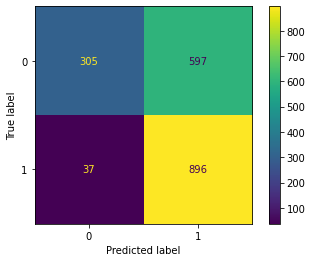

In [123]:
plot_confusion_matrix(dtclf, X_test_tl, y_test_tl)
plt.show()

In [117]:
rfclf= RandomForestClassifier(max_depth = 10, max_features= 25, n_estimators= 100,class_weight= {0:1,1:5})
rfclf= rfclf.fit(X_train_tl,y_train_tl)

In [118]:
y_pred_tl = rfclf.predict(X_test_tl)
print(accuracy_score(y_test_tl,y_pred_tl))
print(classification_report(y_test_tl, y_pred_tl))

0.6931880108991826
              precision    recall  f1-score   support

           0       0.86      0.45      0.59       902
           1       0.64      0.93      0.76       933

    accuracy                           0.69      1835
   macro avg       0.75      0.69      0.67      1835
weighted avg       0.75      0.69      0.67      1835



C:\Users\Abhishek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


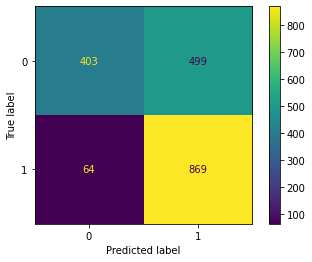

In [122]:
plot_confusion_matrix(rfclf, X_test_tl, y_test_tl)
plt.show()

In [119]:
nbclf = GaussianNB()
nbclf = nbclf.fit(X_train_tl, y_train_tl)

In [120]:
y_pred_tl = nbclf.predict(X_test_tl)
print(accuracy_score(y_test_tl,y_pred_tl))
print(classification_report(y_test_tl, y_pred_tl))

0.6016348773841962
              precision    recall  f1-score   support

           0       0.57      0.76      0.65       902
           1       0.66      0.45      0.53       933

    accuracy                           0.60      1835
   macro avg       0.62      0.60      0.59      1835
weighted avg       0.62      0.60      0.59      1835



C:\Users\Abhishek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


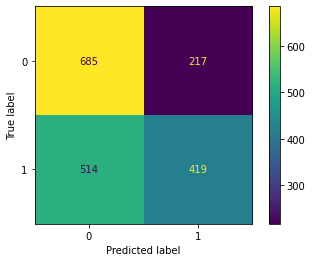

In [121]:
plot_confusion_matrix(nbclf, X_test_tl, y_test_tl)
plt.show()